<br>

<div align=center><font color=maroon size=6><b>Overfit and underfit</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TF2 official tutorials: <a href="https://www.tensorflow.org/tutorials" style="text-decoration:none;">TensorFlow Tutorials</a> 
    * `TensorFlow > Learn > TensorFlow Core > `Tutorials > <a href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit" style="text-decoration:none;">Overfit and underfit</a>
        * Run in <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb" style="text-decoration:none;">Google Colab</a>

<br>
<br>
<br>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would ***overfit*** to the training data. Learning how to deal with overfitting is important. <font color=maroon3 size=3>Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).</font>

The opposite of overfitting is ***underfitting***. Underfitting occurs when there is still room for improvement on the train data. <font color=maroon size=3>This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.</font>

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. <font color=maroon size=3>You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.</font>

<font color=maroon size=3>To prevent overfitting, the best solution is to use more complete training data.</font> The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, <font color=maroon size=3>the next best solution is to use techniques like regularization.</font> These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.


<br><br>

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

<br>
<br>

## Setup

Before getting started, import the necessary packages:

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
print(tf.__version__)

2.5.0


In [3]:
# !pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

<br>

In [5]:
# help(tempfile.mktemp)

In [6]:
logdir = pathlib.Path(tempfile.mktemp(dir="./log"))/"tensorboard_logs"

shutil.rmtree(logdir, ignore_errors=True)

In [7]:
logdir

# 注意，这个在 windows 系统输出的类似是：WindowsPath('log/tmp_g1gn_qp/tensorboard_logs')
# 注意，这个在 unix 系统输出的类似是：PosixPath('/tmp/tmp6ix97zg9/tensorboard_logs')

WindowsPath('log/tmpuro6p73k/tensorboard_logs')

<br>
<br>
<br>

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [8]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [9]:
FEATURES = 28

<br>

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [10]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

<br>

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [11]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [12]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [13]:
help(ds.batch(10000).map(pack_row).unbatch)

Help on method unbatch in module tensorflow.python.data.ops.dataset_ops:

unbatch() method of tensorflow.python.data.ops.dataset_ops.MapDataset instance
    Splits elements of a dataset into multiple elements.
    
    For example, if elements of the dataset are shaped `[B, a0, a1, ...]`,
    where `B` may vary for each input element, then for each element in the
    dataset, the unbatched dataset will contain `B` consecutive elements
    of shape `[a0, a1, ...]`.
    
    >>> elements = [ [1, 2, 3], [1, 2], [1, 2, 3, 4] ]
    >>> dataset = tf.data.Dataset.from_generator(lambda: elements, tf.int64)
    >>> dataset = dataset.unbatch()
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3, 1, 2, 1, 2, 3, 4]
    
    Note: `unbatch` requires a data copy to slice up the batched tensor into
    smaller, unbatched tensors. When optimizing performance, try to avoid
    unnecessary usage of `unbatch`.
    
    Returns:
      A `Dataset`.



<br>

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


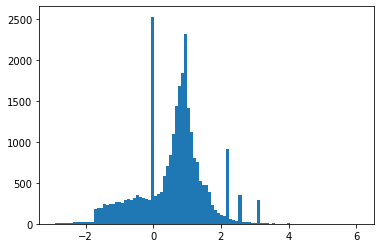

In [14]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

<br>

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [15]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

<br>

<font size=3 color=maroon>The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:</font>

In [16]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [17]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

<br>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [18]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [19]:
train_ds

<BatchDataset shapes: ((None, 28), (None,)), types: (tf.float32, tf.float32)>

<br>
<br>
<br>

## Demonstrate overfitting

<font color=maroon size=3>The simplest way to prevent overfitting is to **start with a small model**:</font> A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). <font color=maroon size=3>In deep learning, the number of learnable parameters in a model is often referred to as the model's "**capacity**".</font>

<font color=maroon size=3>Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

**Always keep this in mind**: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. <ins>There is a balance between "too much capacity" and "not enough capacity".</ins></font>

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). <font color=maroon size=4>You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.</font>

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

<br>

### Training procedure

<font color=maroon size=3>Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:</font>

In [20]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                             decay_steps=STEPS_PER_EPOCH*1000,
                                                             decay_rate=1,
                                                             staircase=False
                                                            )

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

<br>

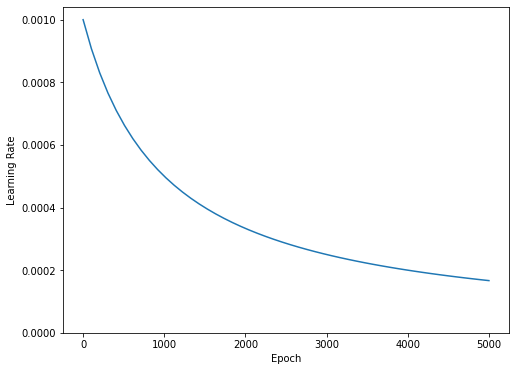

In [21]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

<br>

<font size=3>Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.<br><br>

<font color=maroon>Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.</font>

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.</font>


In [22]:
def get_callbacks(name):
    return [tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
            tf.keras.callbacks.TensorBoard(logdir/name),
           ]

<br>

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [23]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                              name='binary_crossentropy'),
                           'accuracy'])

    model.summary()

    history = model.fit(train_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=get_callbacks(name),
                        verbose=0
                       )
    return history

<br>
<br>

### Tiny model

Start by training a model:

In [24]:
tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
                                  layers.Dense(1)
                                 ])

In [25]:
size_histories = {}

In [26]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4910,  binary_crossentropy:0.7398,  loss:0.7398,  val_accuracy:0.4990,  val_binary_crossentropy:0.7165,  val_loss:0.7165,  
....................................................................................................
Epoch: 100, accuracy:0.6006,  binary_crossentropy:0.6249,  loss:0.6249,  val_accuracy:0.5700,  val_binary_crossentropy:0.6265,  val_loss:0.6265,  
....................................................................................................
Epoch: 200, accuracy:0.62

<br>

Now check how the model did:

(0.5, 0.7)

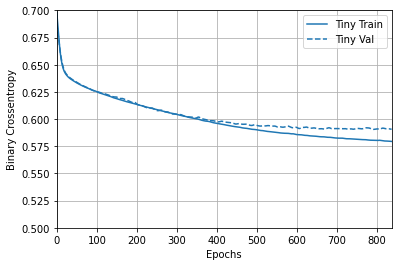

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

<br>
<br>

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [28]:
small_model = tf.keras.Sequential([
                                    # `input_shape` is only required here so that `.summary` works.
                                    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
                                    layers.Dense(16, activation='elu'),
                                    layers.Dense(1)
                                   ])

In [29]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4885,  binary_crossentropy:0.7473,  loss:0.7473,  val_accuracy:0.4510,  val_binary_crossentropy:0.7287,  val_loss:0.7287,  
....................................................................................................
Epoch: 100, accuracy:0.6266,  binary_crossentropy:0.6101,  loss:0.6101,  val_accuracy:0.5990,  val_binary_crossentropy:0.6154,  val_loss:0.

<br>
<br>

### Medium model

Now try three hidden layers with 64 units each:

In [30]:
medium_model = tf.keras.Sequential([layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(1)
                                   ])

And train the model using the same data:

In [31]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5000,  binary_crossentropy:0.7128,  loss:0.7128,  val_accuracy:0.4690,  val_binary_crossentropy:0.6857,  val_loss:0.6857,  
....................................................................................................
E

<br>
<br>

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [32]:
large_model = tf.keras.Sequential([layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
                                   layers.Dense(512, activation='elu'),
                                   layers.Dense(512, activation='elu'),
                                   layers.Dense(512, activation='elu'),
                                   layers.Dense(1)
                                  ])

And, again, train the model using the same data:

In [33]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5130,  binary_crossentropy:0.7695,  loss:0.7695,  val_accuracy:0.4870,  val_binary_crossentr

<br>
<br>

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

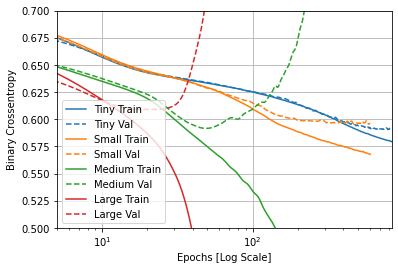

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

<font color=maroon size=3>**Note**:</font> All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

<br>
<br>

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [35]:
logdir         # 注意，这个输出的是 windows 格式的文件路径

WindowsPath('log/tmpuro6p73k/tensorboard_logs')

In [36]:
str(logdir)

'log\\tmpuro6p73k\\tensorboard_logs'

In [37]:
pwd = %pwd    # 注意，这个输出的是 linux 格式的文件路径
print(pwd)

D:\KeepStudy\0_Coding\Tensorflow\tf2_tutorials\1 Beginner\1 ML basics with Keras


In [38]:
%echo {logdir}/sizes   # 注意，这个输出的是 windows 和 linux 混合格式的文件路径

log\tmpuro6p73k\tensorboard_logs/sizes   # 娉ㄦ剰锛岃繖涓�杈撳嚭鐨勬槸 windows 鍜� linux 娣峰悎鏍煎紡鐨勬枃浠惰矾寰�


In [39]:
import os

# os.getcwd()
logdir_2 = os.path.join(logdir, "sizes")
logdir_2

'log\\tmpuro6p73k\\tensorboard_logs\\sizes'

In [40]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/sizes    # 这一句需要修改一下，才能打开。
%tensorboard --logdir ./log/tmp_g1gn_qp/tensorboard_logs/sizes

Reusing TensorBoard on port 6006 (pid 20884), started 0:59:40 ago. (Use '!kill 20884' to kill it.)

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [41]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

<br>

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

<br>
<br>
<br>

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [42]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('log/tmpuro6p73k/tensorboard_logs/regularizers/Tiny')

In [43]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

<br>
<br>

### Add weight regularization

You may be familiar with <font color=blue size=3>**Occam's Razor principle**</font>: <font color=maroon>given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions.</font> This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* <a href="https://developers.google.com/machine-learning/glossary/#L1_regularization" style="text-decoration:none;font-size:110%;color:blue;font-weight:bold;">L1 regularization</a>, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* <a href="https://developers.google.com/machine-learning/glossary/#L2_regularization" style="text-decoration:none;font-size:110%;color:blue;font-weight:bold;">L2 regularization</a>, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

<font color=maroon size=3>L1 regularization pushes weights towards exactly zero, encouraging a sparse model. 
    
L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.</font>

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

<br>

In [44]:
l2_model = tf.keras.Sequential([layers.Dense(512, 
                                             activation='elu', 
                                             kernel_regularizer=regularizers.l2(0.001),
                                             input_shape=(FEATURES,)),
                                layers.Dense(512,
                                             activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(512,
                                             activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(512, 
                                             activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(1)
                               ])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5047,  binary_crossentropy:0.8265,  loss:2.3507,  val_accuracy:0.4850,  val_binary_crossentr

<br>

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

<font color=maroon size=4>That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.</font>

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


<br>

(0.5, 0.7)

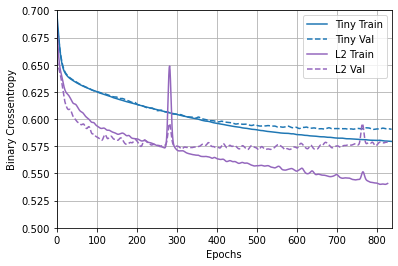

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

<br>

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

<br>

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [46]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [47]:
# help(tf.add_n)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

<br>
<br>

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [48]:
dropout_model = tf.keras.Sequential([layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(1)
                                    ])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

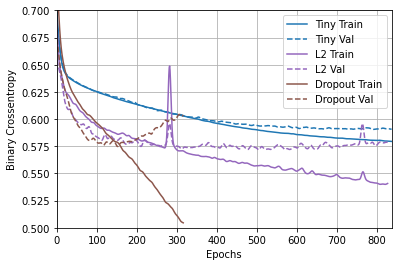

In [49]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

<br>
<br>

### Combined L2 + dropout

In [50]:
combined_model = tf.keras.Sequential([layers.Dense(512,
                                                   kernel_regularizer=regularizers.l2(0.0001),
                                                   activation='elu', input_shape=(FEATURES,)),
                                      layers.Dropout(0.5),
                                      layers.Dense(512,
                                                   kernel_regularizer=regularizers.l2(0.0001),
                                                   activation='elu'),
                                      layers.Dropout(0.5),
                                      layers.Dense(512, 
                                                   kernel_regularizer=regularizers.l2(0.0001),
                                                   activation='elu'),
                                      layers.Dropout(0.5),
                                      layers.Dense(512, 
                                                   kernel_regularizer=regularizers.l2(0.0001),
                                                   activation='elu'),
                                      layers.Dropout(0.5),
                                      layers.Dense(1)
                                     ])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

<br>

(0.5, 0.7)

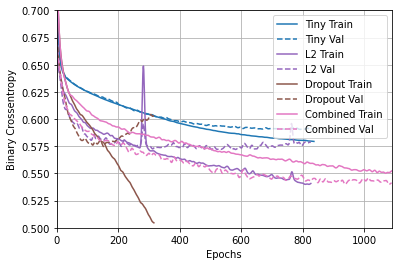

In [51]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

<br>

This model with the `"Combined"` regularization is obviously the best one so far.

<br>
<br>

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

<br>

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

```python
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")
```

This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

<br>

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.

<br>
<br>
<br>

```python
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
```

<br>
<br>
<br>